In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Find available  dataset names in seaborn
print(sns.get_dataset_names())

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic']


In [3]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
# We get only year and month for the date, we need day also

# Convert the date to a YYYY-MM-DD format in a new column named yearMonth
df['yearMonth'] = "01-" + df['month'].astype(str) + "-" + df['year'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
 3   yearMonth   144 non-null    object  
dtypes: category(1), int64(2), object(1)
memory usage: 4.0+ KB


In [5]:
# yearMonth is aof type object  - we may have problems later, so convert it into datetime
df['yearMonth'] = pd.to_datetime(df['yearMonth'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        144 non-null    int64         
 1   month       144 non-null    category      
 2   passengers  144 non-null    int64         
 3   yearMonth   144 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 4.0 KB


In [6]:
# Make yearMonth column as the dataframe index

df.set_index('yearMonth', inplace = True)
df.head()

,year,month,passengers
yearMonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


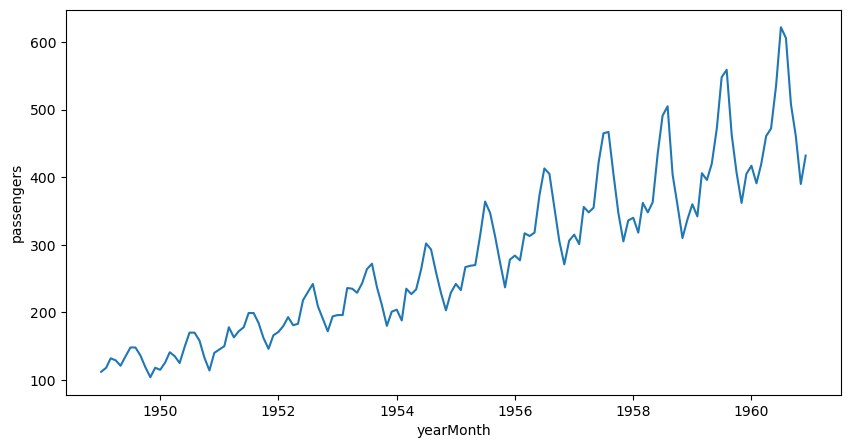

In [7]:
plt.figure(figsize = (10, 5))
sns.lineplot(data = df, x = df.index, y = df.passengers)
plt.show()

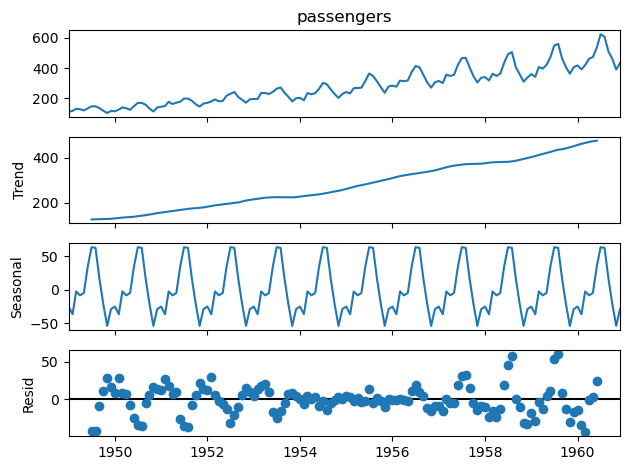

In [8]:
# Check further for seasonality and trend
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.passengers, period = 12)
fig = decomposition.plot()
plt.show()
# Upward trend and clear seasonality

In [9]:
# Calculate and plot rolling mean and standard deviation for 12 months
df['rollMean'] = df.passengers.rolling(window = 12).mean()
df['rollStd'] = df.passengers.rolling(window = 12).std()

print(df['rollMean'])
print(df["rollStd"])

yearMonth
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
                 ...    
1960-08-01    463.333333
1960-09-01    467.083333
1960-10-01    471.583333
1960-11-01    473.916667
1960-12-01    476.166667
Name: rollMean, Length: 144, dtype: float64
yearMonth
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
                ...    
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125
Name: rollStd, Length: 144, dtype: float64


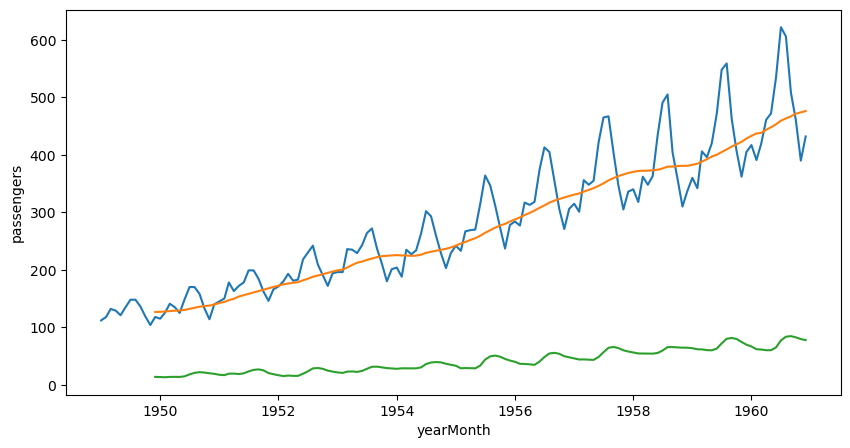

In [10]:
plt.figure(figsize = (10, 5))
sns.lineplot(data =df, x = df.index, y = df.passengers)
sns.lineplot(data = df, x = df.index, y = df.rollMean)
sns.lineplot(data = df, x = df.index, y = df.rollStd)
plt.show()

In [11]:
# Conclusion Mean is not stationary, SD is stationary ; so our data is not stationary

# Now let us perform and ADF test
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(df['passengers'])
print(adfTest)
stats = pd.Series(adfTest[0:4], index = ["Test Statistic", "P-value", "# lags used", "Number of observations"])
print(stats)


(0.8153688792060547, 0.9918802434376411, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
Test Statistic              0.815369
P-value                     0.991880
# lags used                13.000000
Number of observations    130.000000
dtype: float64


In [12]:


# H0 : Time series is not stationary
# p-value >= 0.05: Do no reject the null hypothesis
# ADF statistic is less negative(or more positive) than the critical value
# Do not reject the null hypothesis, meaning the series is non-stationary

for key, values in adfTest[4].items():
    print("criticality", key, ":", values)

# We will see that our Test statistic > Critical value in all the cases, so we do not reject the nul hypothesis. It means that our data is not stationary.


criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


In [13]:
# The time series data can only be analyzed by making it stationary.

# How to make data Stationary

# three methods can be used to make the time series stationary

def test_stationarity(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window = 12).mean()
    dataFrame["rollStd"] = dataFrame[var].rolling(window = 12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var])
    stats = pd.Series(adfTest[0:4], index = ['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality', key, ":", values)

    sns.lineplot(data = dataFrame, x = dataFrame.index, y = var)
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = 'rollMean')
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = "rollStd")
    plt.show()


    



In [14]:
# Just get the passengers column into a new dataFrame for easier testing 
air_df = df[['passengers']].copy() # Double brackets because it is a list within a list 
print(air_df.head())



            passengers
yearMonth             
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [15]:
# Create a new column which will contain the shifted value from passengers column - See slide 
air_df['shift'] = air_df.passengers.shift(1)
air_df['firstDiff'] = air_df['passengers'] - air_df['shift']
print(air_df.head(20))

            passengers  shift  firstDiff
yearMonth                               
1949-01-01         112    NaN        NaN
1949-02-01         118  112.0        6.0
1949-03-01         132  118.0       14.0
1949-04-01         129  132.0       -3.0
1949-05-01         121  129.0       -8.0
1949-06-01         135  121.0       14.0
1949-07-01         148  135.0       13.0
1949-08-01         148  148.0        0.0
1949-09-01         136  148.0      -12.0
1949-10-01         119  136.0      -17.0
1949-11-01         104  119.0      -15.0
1949-12-01         118  104.0       14.0
1950-01-01         115  118.0       -3.0
1950-02-01         126  115.0       11.0
1950-03-01         141  126.0       15.0
1950-04-01         135  141.0       -6.0
1950-05-01         125  135.0      -10.0
1950-06-01         149  125.0       24.0
1950-07-01         170  149.0       21.0
1950-08-01         170  170.0        0.0


Test Statistic                  -2.829267
p-value                          0.054213
#lags used                      12.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_17788\3739322442.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window = 12).mean()
C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_17788\3739322442.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame["rollStd"] = dataFrame[var].rolling(window = 12).std()


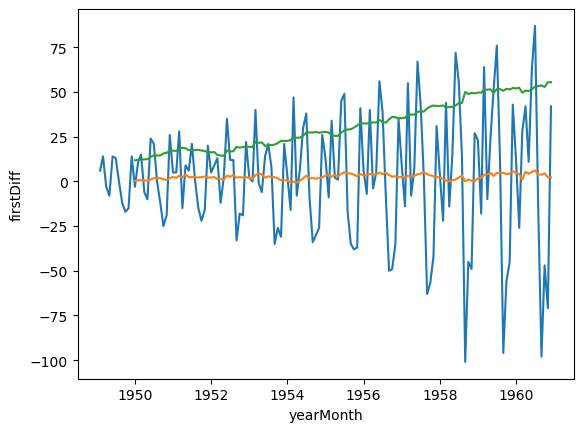

In [16]:
# Test stationarity
test_stationarity(air_df.dropna(), 'firstDiff')

In [17]:

air_df['shift'] = air_df.passengers.shift(2)
air_df['secondDiff'] = air_df['passengers'] - air_df['shift']
print(air_df.head(20))

            passengers  shift  firstDiff  secondDiff
yearMonth                                           
1949-01-01         112    NaN        NaN         NaN
1949-02-01         118    NaN        6.0         NaN
1949-03-01         132  112.0       14.0        20.0
1949-04-01         129  118.0       -3.0        11.0
1949-05-01         121  132.0       -8.0       -11.0
1949-06-01         135  129.0       14.0         6.0
1949-07-01         148  121.0       13.0        27.0
1949-08-01         148  135.0        0.0        13.0
1949-09-01         136  148.0      -12.0       -12.0
1949-10-01         119  148.0      -17.0       -29.0
1949-11-01         104  136.0      -15.0       -32.0
1949-12-01         118  119.0       14.0        -1.0
1950-01-01         115  104.0       -3.0        11.0
1950-02-01         126  118.0       11.0         8.0
1950-03-01         141  115.0       15.0        26.0
1950-04-01         135  126.0       -6.0         9.0
1950-05-01         125  141.0      -10.0      

Test Statistic                  -2.961695
p-value                          0.038630
#lags used                      11.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_17788\3739322442.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window = 12).mean()
C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_17788\3739322442.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame["rollStd"] = dataFrame[var].rolling(window = 12).std()


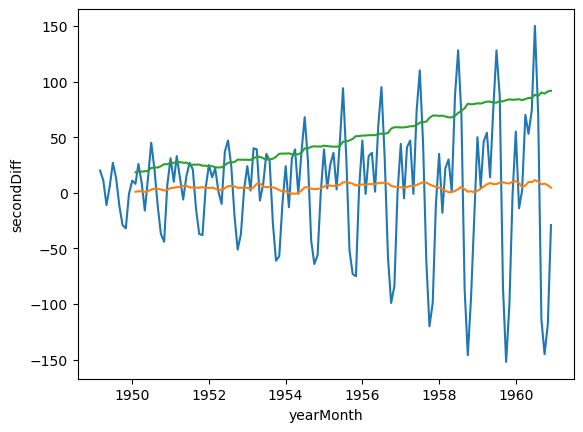

In [18]:
test_stationarity(air_df.dropna(), 'secondDiff')

In [19]:
# Test stationarity 
# p-value = 0.03, which is < 0.05, so, 
# Conclusion: The data has become somewhat stationary

In [20]:
# ARIMA

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

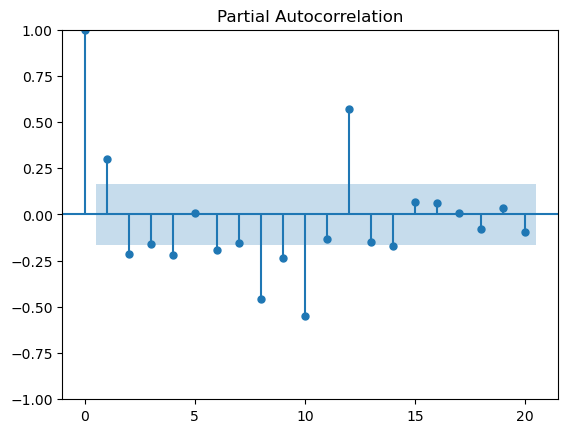

In [22]:
plot_pacf(air_df['firstDiff'].dropna(), lags = 20)
plt.show()

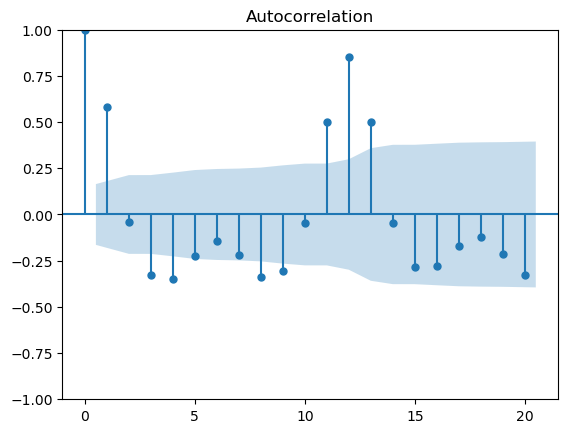

In [23]:
plot_acf(air_df['secondDiff'].dropna(), lags = 20)
plt.show()

In [24]:

# Build ARIMA model
train = air_df[:round(len(air_df) * 70 / 100)] # Take the first 70% data
print(train.tail())

            passengers  shift  firstDiff  secondDiff
yearMonth                                           
1957-01-01         315  271.0        9.0        44.0
1957-02-01         301  306.0      -14.0        -5.0
1957-03-01         356  315.0       55.0        41.0
1957-04-01         348  301.0       -8.0        47.0
1957-05-01         355  356.0        7.0        -1.0


In [25]:
test = air_df[round(len(air_df) * 70 / 100):] # Take the last 30% data
print(test.head())

            passengers  shift  firstDiff  secondDiff
yearMonth                                           
1957-06-01         422  348.0       67.0        74.0
1957-07-01         465  355.0       43.0       110.0
1957-08-01         467  422.0        2.0        45.0
1957-09-01         404  465.0      -63.0       -61.0
1957-10-01         347  467.0      -57.0      -120.0


In [26]:
model = ARIMA(train['passengers'], order = (1, 2, 1)) # Parameters: p, d, q
model_fit = model.fit()
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
air_df['arimaPred'] = prediction
print(air_df.tail())



            passengers  shift  firstDiff  secondDiff   arimaPred
yearMonth                                                       
1960-08-01         606  535.0      -16.0        71.0  451.948123
1960-09-01         508  622.0      -98.0      -114.0  454.401429
1960-10-01         461  606.0      -47.0      -145.0  456.854734
1960-11-01         390  508.0      -71.0      -118.0  459.308040
1960-12-01         432  461.0       42.0       -29.0  461.761345


C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


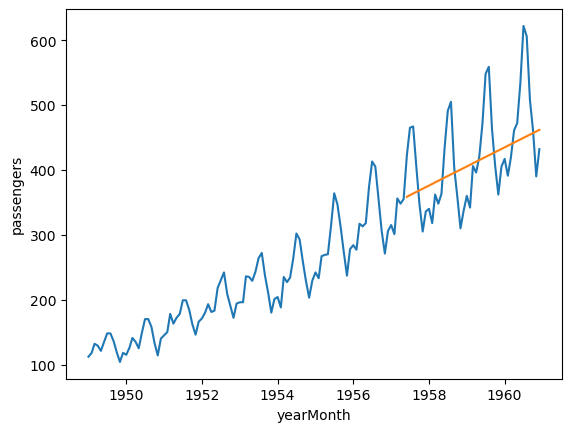

In [27]:
sns.lineplot(data = air_df, x = air_df.index, y = 'passengers')
sns.lineplot(data = air_df, x = air_df.index, y = 'arimaPred')
plt.show()
# Conclusion: The ARIMA prediction is not good

In [28]:
air_df["diff12"] = air_df["passengers"].diff(12)


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [67]:
model = SARIMAX(train['passengers'], order = (1, 2, 1), seasonal_order = (1, 2, 1, 12))
model_fit = model.fit()
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
air_df['sarimaxPred'] = prediction
print(air_df.tail())

C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            passengers  shift  firstDiff  secondDiff   arimaPred  diff12  \
yearMonth                                                                  
1960-08-01         606  535.0      -16.0        71.0  451.948123    47.0   
1960-09-01         508  622.0      -98.0      -114.0  454.401429    45.0   
1960-10-01         461  606.0      -47.0      -145.0  456.854734    54.0   
1960-11-01         390  508.0      -71.0      -118.0  459.308040    28.0   
1960-12-01         432  461.0       42.0       -29.0  461.761345    27.0   

            sarimaxPred  
yearMonth                
1960-08-01   588.726547  
1960-09-01   518.337264  
1960-10-01   452.559438  
1960-11-01   402.779885  
1960-12-01   450.755451  


In [69]:
# Plot
# air_df = air_df.dropna()
print(air_df.head())




            passengers  shift  firstDiff  secondDiff  arimaPred  diff12  \
yearMonth                                                                 
1949-01-01         112    NaN        NaN         NaN        NaN     NaN   
1949-02-01         118    NaN        6.0         NaN        NaN     NaN   
1949-03-01         132  112.0       14.0        20.0        NaN     NaN   
1949-04-01         129  118.0       -3.0        11.0        NaN     NaN   
1949-05-01         121  132.0       -8.0       -11.0        NaN     NaN   

            sarimaxPred  
yearMonth                
1949-01-01          NaN  
1949-02-01          NaN  
1949-03-01          NaN  
1949-04-01          NaN  
1949-05-01          NaN  


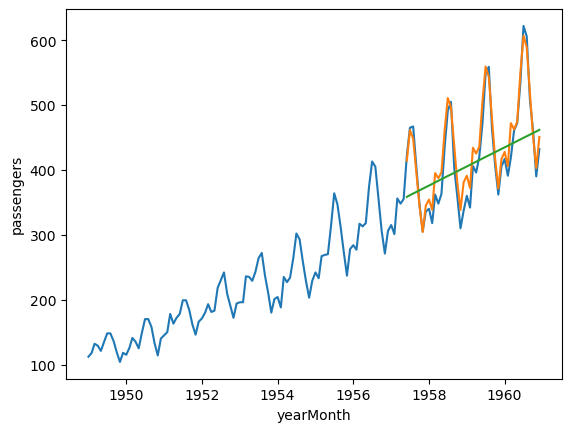

In [71]:
sns.lineplot(data = air_df, x = air_df.index, y = "passengers")
sns.lineplot(data = air_df, x = air_df.index, y = "sarimaxPred")
sns.lineplot(data = air_df, x = air_df.index, y = "arimaPred")
plt.show()

In [73]:
# Create a data frame t ohold index values from 01.01.61 to 01.12.62
futureDate = pd.DataFrame(pd.date_range(start = "1961-01-01", end = "1962-12-01", freq = "MS"), columns = ["Dates"])
futureDate.set_index("Dates", inplace = True)
print(futureDate.head())

Empty DataFrame
Columns: []
Index: [1961-01-01 00:00:00, 1961-02-01 00:00:00, 1961-03-01 00:00:00, 1961-04-01 00:00:00, 1961-05-01 00:00:00]


In [77]:
print(model_fit.predict(start = futureDate.index[0], end = futureDate.index[-1]))



1961-01-01    462.520429
1961-02-01    437.510284
1961-03-01    508.309257
1961-04-01    497.686178
1961-05-01    510.988031
1961-06-01    591.629112
1961-07-01    652.282661
1961-08-01    631.977321
1961-09-01    555.794849
1961-10-01    485.292074
1961-11-01    431.938781
1961-12-01    482.499552
1962-01-01    494.900354
1962-02-01    466.739858
1962-03-01    541.889791
1962-04-01    530.260293
1962-05-01    544.983812
1962-06-01    630.668469
1962-07-01    694.773172
1962-08-01    672.324835
1962-09-01    590.249489
1962-10-01    514.932337
1962-11-01    457.956298
1962-12-01    511.004895
Freq: MS, Name: predicted_mean, dtype: float64


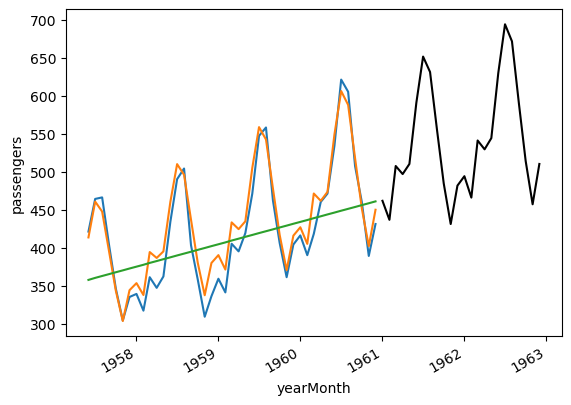

In [79]:
# Plot 

air_df.dropna(inplace = True)
sns.lineplot(data = air_df, x = air_df.index, y = "passengers")
sns.lineplot(data = air_df, x = air_df.index, y = "sarimaxPred")
sns.lineplot(data = air_df, x = air_df.index, y = "arimaPred")
model_fit.predict(start = futureDate.index[0], end = futureDate.index[-1]).plot(color = 'black')
plt.show()